**Tarif Engine**

Classes

TarEng

Demogr

Economics

Tariff

**General Parameters (configurable via bDefaultsInput)**

t0: currrent year (default - current year)

g: gender (0 - man; 1 - woman - default 0)

x: current age

b: start age of benefits (default b=x)

s: end age benefits (default - omega)

Other Defaults: ATar, QxCH, iTech

**GTar**

Inputs:

fB: Death Benefit Level

fM: Maturity Benefit

**ATar**

Inputs:

fR: Annuity Benefit Start

fDeltaR: Linear increase relative to fR

iNrIncreases: Nr of Benefit Increases




In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime

class MyIO:
    def __init__(self, strName):
        self.me = strName

    def getvariablenames(self):
        members = [attr for attr in dir(self) if not \
                 callable(getattr(self, attr)) and not attr.startswith("__")] 
        return(members)
    
    def clean(self):
        strName = self.me
        members = self.getvariablenames()
        for i in members: 
            strTask = "self."+i+"= None"
            exec(strTask)
        self.me = strName
    
    def print(self):
        instance_vars = vars(self)
        for v_name, v_value in instance_vars.items():
            print("%s --> %s"%(repr(v_name),repr(v_value)))

    def vstrPrint(self):
        instance_vars = vars(self)
        strOut = "Trace %s \n------------ \n"%(self.me)
        for v_name, v_value in instance_vars.items():
            strOut+= "%s --> %s \n"%(repr(v_name),repr(v_value))
        strOut +="------------ \n"
        return(strOut)
    
class TarEng():
    def __init__(self,i=0.025, t0= 2025, omega=120,nCF=100,bDefaultsInput = True,bLevel=False,bBatch=False,bTrace=False):
        self.strVersion = "Tariff Engine V0.20 M Koller"
        self.symDirTariffs = dict()
        self.symDirDemogr = dict()
        self.symDirEco = dict()
        self.pInp = MyIO("Input")
        self.pOut = MyIO("Output")
        self.pTrace = MyIO("Trace")
        self.pGPar = MyIO("GlobalParameter")
        self.pGPar.iTech = i
        self.pGPar.vTech = 1./(1.+i)
        self.pGPar.t0 = t0
        self.pGPar.omega=omega
        self.pGPar.nCF=nCF
        self.AddModules()
        self.bDefaultsInput = bDefaultsInput
        self.pInp.Tarif = None
        self.pInp.Econ = None
        self.pInp.Demo = None
        self.bLevel = bLevel
        self.bBatch = bBatch
        self.bTrace = bTrace
        self.pInp.Param = dict()
        

    def AddModules(self):
        self.symDirTariffs = {"A":ATar,"A2":A2Tar,"G":GTar,\
                              "A..":ATar,"AR.":ATar,"A.E":ATar,"ARE":ATar,"A.L":ATar,"ARL":ATar,\
                              "ART":ATar,"G..":GTar,"F..":GTar,\
                              "T..":GTar,"L..":GTar,"W..":A2Tar}
        self.symDirDemogr = {"CH":QxCH}
        self.symDirEco ={"iTech":ITech}
        
    def vPostProcess(self):
        Mapper={"A..":self.AMod,"AR.":self.AMod,"A.E":self.AMod,"ARE":self.AMod, "A.L":self.AMod,"ARL":self.AMod,\
                "ART":self.AMod,"G..":self.GMod,"F..":self.GMod,\
                "T..":self.GMod,"L..":self.GMod,"W..":self.WMod}
        if self.pInp.Tarif in Mapper.keys():
            Mapper[self.pInp.Tarif]()
        return()

    def AMod(self):
        if self.pInp.Tarif == "AR." or self.pInp.Tarif == "A.." or self.pInp.Tarif == "ART":
            self.pInp.Param["alpha"] = 0.
            self.pInp.Param["iNrIncreases"] = 0
            self.pInp.Param["iExp"] = 0
        if self.pInp.Tarif == "AR." or self.pInp.Tarif == "ARE" or self.pInp.Tarif == "ARL" or self.pInp.Tarif == "ART":
            self.pInp.Param["b"] = self.pInp.Param["x"]
        if self.pInp.Tarif == "ARL" or self.pInp.Tarif == "A.L":
            self.pInp.Param["iExp"] = 0
            self.pInp.Param["iNrIncreases"] = 1000
        if self.pInp.Tarif == "ARE" or self.pInp.Tarif == "A.E":
            self.pInp.Param["iExp"] = 1
            self.pInp.Param["iNrIncreases"] = 1000
        if self.pInp.Tarif != "ART":
               self.pInp.Param["s"] = self.pGPar.omega

    def GMod(self):
        self.pInp.Param["b"] = self.pInp.Param["x"]
        if self.pInp.Tarif == "G..":
            self.pInp.Param["fM"] = 1
            self.pInp.Param["fB"] = 1 
        if self.pInp.Tarif == "L..":
            self.pInp.Param["fM"] = 1
            self.pInp.Param["fB"] = 1 
            self.pInp.Param["s"] = self.pGPar.omega
        if self.pInp.Tarif == "T..":
            self.pInp.Param["fM"] = 0
            self.pInp.Param["fB"] = 1 
        if self.pInp.Tarif == "F..":
            self.pInp.Param["fM"] = 1
            self.pInp.Param["fB"] = 0 
 
    def WMod(self):
        self.pInp.Param["s"] = self.pGPar.omega
        self.pInp.Param["b"] = self.pInp.Param["x"]
        Tokens=["fM12","fM1","fM2","fR1","fR12","fB1","fB2","fB12"]
        for i in Tokens:
            self.pInp.Param[i] = 0
        self.pInp.Param["fR2"] = 1
        self.pInp.Param["g2"] = 1-int(self.pInp.Param["g"])
            
    
    def ParseTask(self, strInput,strSep=";",bPrintOut=True):
        if self.bBatch: bPrintOut=False
        #print(self.pInp.Tarif)
        #strInput = self.vPreProcess(strInput)
        Tokens=strInput.split(strSep)
        self.pInp.strInp = strInput
        #print(self.pInp.Tarif)
        for i in Tokens:
            #print(self.pInp.Tarif)
            SubTok = i.split("=")
            if len(SubTok) == 1:
                if SubTok[0] in self.symDirTariffs.keys():
                    self.pInp.Tarif = SubTok[0]
                if SubTok[0] in self.symDirDemogr.keys():
                    self.pInp.Demo = SubTok[0]
                if SubTok[0] in self.symDirEco.keys():
                    self.pInp.Econ = SubTok[0]
            else:
                self.pInp.Param[SubTok[0]] = SubTok[1]
        #print(self.pInp.Tarif)
        if self.bDefaultsInput:
            #if self.pInp.Tarif == None:
            #    self.pInp.Tarif = "A"
            if self.pInp.Demo == None:
                self.pInp.Demo = "CH"
            if self.pInp.Econ == None:
                self.pInp.Econ = "iTech"
            self.vDefaultMapper()

       
       # init objects
        self.psymE = self.symDirEco[self.pInp.Econ](self)
        self.psymD = self.symDirDemogr[self.pInp.Demo](self)
        self.psymT = self.symDirTariffs[self.pInp.Tarif](self)

        self.vPostProcess()
        
      # do Stuff
        if not self.bLevel:
            self.pInp.Param["fLevel"] = 1.
        #else:
        #    print("Task:",strInput)
        #    print(repr(self.pInp.Param))

        self.psymE.vDoCalc()
        self.psymD.vDoCalc()
        self.psymT.vDoCalc()

      # print
        if bPrintOut: self.vPrint()
        if self.bTrace: self.TraceIO()
            

    def vDefaultMapper(self):
        strOut = ""
        today = datetime.date.today()
        self.pGPar.t0 = today.year
        dDefaults={"x":15,"g":0,"g2":1,"deltaxy":-3,"fM":1,"fB":1}
        for i in dDefaults.keys():
            if i not in self.pInp.Param.keys():
                self.pInp.Param[i] = dDefaults[i]
        strOut +="Set year to:"+str(self.pGPar.t0)+"\n"
        if "b" not in self.pInp.Param.keys():
            self.pInp.Param["b"] = self.pInp.Param["x"]
            strOut +="Overrule b (missing) \n"
        if "s" not in self.pInp.Param.keys():
            self.pInp.Param["s"] = self.pGPar.omega
            strOut +="Overrule s (missing) \n"
        
        self.pTrace.vDefaultMapperMsg  = strOut
        
    def strPrint(self):
        strStruct2a = "%7s: %20s %20s \n"
        strSep= (len(strStruct2a %("Age","DK/MR","E[CF]"))-1)*"-"+"\n"
        strParam = ["g","g2","x","deltaxy","b","s"]
        strOut = ""
        strOut += strSep
        strOut += self.pInp.Tarif +"\n"
        strOut += strSep
        strStruct1 = "%-15s: %10s \n"
        strStruct2 = "%7d: %20.6f %20.6f \n"
        
        strOut += strStruct1 %("omega",str(self.pGPar.omega))
        strOut += strStruct1 %("t0",str(self.pGPar.t0))
        strOut += strStruct1 %("iTech",str(self.pGPar.iTech))
        for i in strParam:
            bAvailable = (i in self.pInp.Param.keys())
            if bAvailable:
                strOut += strStruct1 %(i,str(self.pInp.Param[i]))
            else:
                strOut += strStruct1 %(i,"n/a")
        for i in self.pInp.Param.keys():
            bDone = (i in strParam)
            if not bDone:
                 strOut += strStruct1 %(i,str(self.pInp.Param[i]))
                
        strOut += strSep
        x= int(self.pInp.Param["x"])
        s= int(self.pInp.Param["s"])
        strOut += strStruct2a %("Age","DK/MR","E[CF]")
        strOut += strSep
        for i in range(x,min(self.pGPar.omega,s+1)):
            strOut += strStruct2 %(i,self.pOut.dDK[i],self.pOut.dCF[i-x])
        return(strOut)

    def vPrint(self):
        print(self.strPrint())
            
    def vPlot(self):
        x=int(self.pInp.Param["x"])
        periods = self.pGPar.nCF
        omega=self.pGPar.omega
        xmax = min(omega,x+periods)
        plt.figure(1)
        plt.plot(range(x,xmax),self.pOut.dDK[x:xmax])
        plt.grid(True)
        plt.figure(2)
        plt.plot(range(0,xmax-x),self.pOut.dCF[0:xmax-x])
        plt.grid(True)
         
    def TraceIO(self):
        strOut = ""
        for i in [self.pInp,self.pOut,self.pTrace,self.pGPar]:
            strOut += i.vstrPrint()
        print(strOut)

    def vClearInput(self):
        self.pInp.clean()
        self.pOut.clean()
        self.pTrace.clean()
        self.pInp.Tarif = None
        self.pInp.Econ = None
        self.pInp.Demo = None
        self.pInp.Param = dict()
        self.TraceIO()
        
        

In [4]:
class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscounT(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t) 
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1

In [7]:

class ATar():
    def __init__(self,psymParent):
        self.psymParent=psymParent

        self.psymB = self.StdBenefit 

        self.psymParent.pOut.dDK= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pOut.dDKPer= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pOut.dBenefitLevel= np.zeros(self.psymParent.pGPar.omega)
        periods = self.psymParent.pGPar.nCF
        self.psymParent.pOut.dCF = np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pTrace.strExecTasks = []
        self.vUpdateParam()

    def vUpdateParam(self):
        self.nOmega = self.psymParent.pGPar.omega
        self.psymQx = self.psymParent.psymD.dQx
        self.dV = self.psymParent.pGPar.vTech
        self.nT0 = self.psymParent.pGPar.t0
    
    def StdBenefit(self,x,param=[]):
#iNrPayments: number of annuity payments
#fR: Annuity Benefit Start
#fDeltaR: Linear increase
#iNrIncreases: Nr of Benefit Increases
        dValue=0
        if x>=self.b and x<self.s: 
           if self.iExp == 0:
               dValue = 1 + self.alpha *max(0,min(x-self.b,self.iNrIncreases))
           else:
               dValue = (1 + self.alpha) ** max(0,min(x-self.b,self.iNrIncreases))

        return(dValue*self.fR)

    def CalcPV(self):

        dDK = self.psymParent.pOut.dDK
        dDKPer = self.psymParent.pOut.dDKPer
        gender = self.gender
        x = self.x
        s = self.s
        b = self.b
        fLevel = self.fLevel
        param = self.param
        PV = 0
        dDK[s] = PV
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            dBen = self.psymB(i,param=param) * fLevel
            self.psymParent.pOut.dBenefitLevel[i]=dBen
            PV = dBen + px * self.dV * PV # a_x = 1 + p_x v a_{x+1}
            dDK[i] = PV
            dDKPer[i-x] = PV
            
    
    def CalcCF(self):
        # Caculation of expected cash flows
        gender = self.gender
        x = self.x
        s = self.s
        b = self.b
        fLevel = self.fLevel
        param = self.param
        periods = self.psymParent.pGPar.nCF
        CF =  self.psymParent.pOut.dCF
        px = 1.
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
 
            dBen = self.psymB(i,param=param) * fLevel
            CF[n] = px  * dBen
            px *= (1-qx)
            #print(i, px, qx)

    def PopulateParam(self):
        
        self.gender = int(self.psymParent.pInp.Param["g"])
        self.x = int(self.psymParent.pInp.Param["x"])
        self.b = int(self.psymParent.pInp.Param["b"])
        self.s = int(self.psymParent.pInp.Param["s"])
        #print(self.psymParent.pInp.Param)
        self.fLevel = float(self.psymParent.pInp.Param["fLevel"])
        Tokens=["iNrIncreases","alpha","fR","iExp"]
        for i in Tokens:
            if i in self.psymParent.pInp.Param.keys():
                dValue =  float(self.psymParent.pInp.Param[i])
            else:
                if i == "fR":
                    dValue = 1
                else:
                    dValue = 0
            strExec="self."+i+"="+str(dValue)
            self.psymParent.pTrace.strExecTasks.append(strExec)
            exec(strExec)
            
        self.param=[]

    def vDoCalc(self):
        self.vUpdateParam()
        #print ("Task :",self.psymParent.pInp.Param)
        self.PopulateParam()
        try:
            self.PopulateParam()
        except:
            print("Error Parameter")
            self.psymParent.TraceIO()
            return()
        self.CalcPV()
        self.CalcCF()


class A2Tar():
    def __init__(self,psymParent):
        self.psymParent=psymParent
        self.psymParent.pOut.dDK= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pOut.dDKPer= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pTrace.dDK12= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pTrace.dDK1= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pTrace.dDK2= np.zeros(self.psymParent.pGPar.omega+1)
        periods = self.psymParent.pGPar.nCF
        self.psymParent.pOut.dCF = np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pTrace.strExecTasks = []

        self.psymB1 = self.ConstantBenefit
        self.psymB2 = self.ConstantBenefit
        self.psymB12 = self.ConstantBenefit
        self.psymR1 = self.ConstantBenefit
        self.psymR2 = self.ConstantBenefit
        self.psymR12 = self.ConstantBenefit
        self.psymM1 = self.ConstantBenefit
        self.psymM2 = self.ConstantBenefit
        self.psymM12 = self.ConstantBenefit
        
        self.symM=Markov()
        self.symM.vDefineModel(4)
        self.QxLevelJoint = 1.
        self.QxLevelWidow = 1.

    def vUpdateParam(self):
        self.nOmega = self.psymParent.pGPar.omega
        self.psymQx = self.psymParent.psymD.dQx
        self.dV = self.psymParent.pGPar.vTech
        self.nT0 = self.psymParent.pGPar.t0
        self.dIrate = self.psymParent.pGPar.iTech
        
    def StdBenefit(self,x,param=[]):
       #iNrPayments: number of annuity payments
       #fR: Annuity Benefit Start
       #fDeltaR: Linear increase
       #iNrIncreases: Nr of Benefit Increases
        dValue=0
        if x>=self.b and x<self.s: 
           dValue = 1 + self.fDeltaR *min(x-self.b,self.iNrIncreases)
        return(dValue*self.fR)

    def ConstantBenefit(self,x,param=[]):
        if x < self.b: return(0)
        return(1.)

    def ZeroBenefit(self,x,param=[]):
        return(0.)    

    def PopulateParam(self):
        self.x = int(self.psymParent.pInp.Param["x"])
        self.s = int(self.psymParent.pInp.Param["s"])
        self.b = int(self.psymParent.pInp.Param["b"])
        self.fLevel = float(self.psymParent.pInp.Param["fLevel"])

        self.gender1 = int(self.psymParent.pInp.Param["g"])
        self.gender2 = int(self.psymParent.pInp.Param["g2"])
        self.deltaxy = int(self.psymParent.pInp.Param["deltaxy"])
        
        self.param=[]
        Tokens=["fM12","fM1","fM2","fR1","fR2","fR12","fB1","fB2","fB12"]
        for i in Tokens:
            if i in self.psymParent.pInp.Param.keys():
                dValue =  float(self.psymParent.pInp.Param[i])
            else:
                dValue = 0
            strExec="self."+i+"="+str(dValue)
            self.psymParent.pTrace.strExecTasks.append(strExec)
            exec(strExec)
    
    def vDoCalc(self):
        self.vUpdateParam()
        #print ("Task :",self.psymParent.pInp.Param)
        try:
            self.PopulateParam()
        except:
            print("Error Parameter")
            self.psymParent.TraceIO()
            return()
        self.CalcPV()
        self.CalcCF()

    def CalcPV(self):
        dDK= self.psymParent.pOut.dDK
        dDKPer = self.psymParent.pOut.dDKPer
        dDK12= self.psymParent.pTrace.dDK12
        dDK1=self.psymParent.pTrace.dDK1
        dDK2=self.psymParent.pTrace.dDK2
        x = self.x
        s = self.s
        fLevel = self.fLevel
        param = self.param
        n  = s-x
        gender1 = self.gender1
        gender2 = self.gender2 
        deltaxy = self.deltaxy
        self.symM.vSetDiscounT(self.dIrate)
        tt=s-1
        self.symM.vSetPost(tt,0,0,self.fM12*self.psymM12(s,param=param)* fLevel)
        self.symM.vSetPost(tt,1,1,self.fM1*self.psymM1(s,param=param)* fLevel)
        self.symM.vSetPost(tt,2,2,self.fM2*self.psymM2(s,param=param)* fLevel)
        for i in range(x,s):
            t = self.nT0 + i - x
            iy = i + deltaxy
            qx = max(0,min(1,self.psymQx(gender1,i,t) * self.QxLevelJoint))
            qy = max(0,min(1,self.psymQx(gender2,iy,t)* self.QxLevelJoint))
            px = 1. - qx
            py = 1. - qy
            qxW = max(0,min(1,self.psymQx(gender1,i,t) * self.QxLevelWidow))
            qyW = max(0,min(1,self.psymQx(gender2,iy,t) * self.QxLevelWidow))
            pxW = 1. - qxW
            pyW = 1. - qyW
            tt = i
            self.symM.vSetPij(tt,0,0,px*py)
            self.symM.vSetPij(tt,0,1,px*qy)
            self.symM.vSetPij(tt,0,2,qx*py)
            self.symM.vSetPij(tt,0,3,qx*qy)
            self.symM.vSetPij(tt,1,1,pxW)
            self.symM.vSetPij(tt,1,3,qxW)
            self.symM.vSetPij(tt,2,2,pyW)
            self.symM.vSetPij(tt,2,3,qyW)
            self.symM.vSetPre(tt,0,0,self.fR12*self.psymR12(i,param=param)* fLevel)
            self.symM.vSetPre(tt,1,1,self.fR1*self.psymR1(i,param=param)* fLevel)
            self.symM.vSetPre(tt,2,2,self.fR2*self.psymR2(i,param=param)* fLevel)
            self.symM.vSetPost(tt,0,1,self.fB12*self.psymB12(i,param=param)* fLevel)
            self.symM.vSetPost(tt,0,2,self.fB12*self.psymB12(i,param=param)* fLevel)
            self.symM.vSetPost(tt,0,3,self.fB12*self.psymB12(i,param=param)* fLevel)
            self.symM.vSetPost(tt,1,3,self.fB1*self.psymB1(i,param=param)* fLevel)
            self.symM.vSetPost(tt,2,3,self.fB2*self.psymB2(i,param=param)* fLevel)
         
        for i in range(x,s):
            dDK1[i] = self.symM.dGetDK(self.nOmega,0,i,1)
            dDK2[i] = self.symM.dGetDK(self.nOmega,0,i,2)
            dDK12[i] = self.symM.dGetDK(self.nOmega,0,i,0)
            dDK[i]=dDK12[i]
            dDKPer[i-x] = dDK12[i]


    def CalcCF(self):
        CF =  self.psymParent.pOut.dCF
        x = self.x
        s = self.s
        fLevel = self.fLevel
        for i in range(x,s):
            CF[i-x]= self.symM.dGetCF(self.nOmega,x,i,0)

class GTar():
    def __init__(self,psymParent):
        self.psymParent=psymParent

        self.psymB = self.ConstantBenefit 
        self.psymM = self.ConstantBenefit # We incialise actually A_x

        self.psymParent.pOut.dDK= np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pOut.dDKPer= np.zeros(self.psymParent.pGPar.omega+1)
        periods = self.psymParent.pGPar.nCF
        self.psymParent.pOut.dCF = np.zeros(self.psymParent.pGPar.omega+1)
        self.psymParent.pTrace.strExecTasks = []
        self.vUpdateParam()      
    
    def vUpdateParam(self):
        self.nOmega = self.psymParent.pGPar.omega
        self.dV = self.psymParent.pGPar.vTech
        self.nT0 = self.psymParent.pGPar.t0
        self.psymQx = self.psymParent.psymD.dQx
    
    def ConstantBenefit(self,x,param=[]):
        if x < self.b: return(0)
        return(1.)

    def ZeroBenefit(self,x,param=[]):
        return(0.)    

    def PopulateParam(self):
        self.gender = int(self.psymParent.pInp.Param["g"])
        self.x = int(self.psymParent.pInp.Param["x"])
        self.s = int(self.psymParent.pInp.Param["s"])
        self.b = int(self.psymParent.pInp.Param["b"])
        self.fLevel = float(self.psymParent.pInp.Param["fLevel"])

        Tokens=["fM","fB"]
        for i in Tokens:
            if i in self.psymParent.pInp.Param.keys():
                dValue =  float(self.psymParent.pInp.Param[i])
            else:
                dValue = 0
            strExec="self."+i+"="+str(dValue)
            self.psymParent.pTrace.strExecTasks.append(strExec)
            exec(strExec)
        
        self.fB = int(self.psymParent.pInp.Param["fB"])
        self.fM = int(self.psymParent.pInp.Param["fM"])
        self.param=[]

    def CalcPV(self):
        self.vUpdateParam()
        dDK = self.psymParent.pOut.dDK
        dDKPer = self.psymParent.pOut.dDKPer
        gender = self.gender
        x = self.x
        s = self.s
        fLevel = self.fLevel
        param = self.param
        # Calculation of present value by means of recursion
        PV = self.psymM(s,param=param) * self.fM * fLevel
        dDK[s] = PV
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param)*self.fB* fLevel + px * self.dV * PV
            dDK[i] = PV
            dDKPer[i-x] = PV
    
    def CalcCF(self):
        # Caculation of expected cash flows
        gender = self.gender
        x = self.x
        s = self.s
        fLevel = self.fLevel
        param = self.param
        periods = self.psymParent.pGPar.nCF
        CF =  self.psymParent.pOut.dCF
        px = 1.
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px * qx * self.psymB(i,param=param)* fLevel
            px *= (1-qx)
            #print(i, px, qx)
        
        n = s - x
        if n < periods:
            CF[n] = px * self.psymM(s,param=param)* fLevel
    
    def vDoCalc(self):
        #print ("Task :",self.psymParent.pInp.Param)
        try:
            self.PopulateParam()
        except:
            print("Error Parameter")
            self.psymParent.TraceIO()
            return()
            
        self.CalcPV()
        self.CalcCF()

class QxCH():
    def __init__(self,psymParent):
        self.psymParent=psymParent
        self.psymParent.pOut.strHelloQx = "Hello QX"
        self.dQx=self.Qx
    
    def Qx(self,gender,x,t,param =[]):
        # This is our default mortality
        if gender == 0:
            a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
        else:
            a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
        return(min(1,max(0,np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))))

    def QxNoReduction(self,gender,x,t,param =[]):
        # This is our default mortality
        t = self.psymParent.pGPar.t0
        if gender == 0:
            a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
        else:
            a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
        return(min(1,max(0,np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))))

    def QxMedieval(self,gender,x,t,param =[]):
        a=-9.13275
        b= 8.09432e-2
        c= -1.1018e-5
        value=math.exp(a+(b+c*x)*x)
        alpha = 7.26502413
        beta = 0.01342065
        return(max(0,min(1,alpha*value+beta)))

    def vDoCalc(self):
        strTokens ={"Std":self.Qx,"NoRed":self.QxNoReduction,"Medieval":self.QxMedieval}
        if "QX" in self.psymParent.pInp.Param.keys():
            if self.psymParent.pInp.Param["QX"] in strTokens.keys():
                print("Update Mortality to:",self.psymParent.pInp.Param["QX"])
                self.dQx = strTokens[self.psymParent.pInp.Param["QX"]]
                

class ITech():
    def __init__(self,psymParent):
        self.psymParent=psymParent

    def vDoCalc(self):
        if "fI" in self.psymParent.pInp.Param.keys():
            i = float(self.psymParent.pInp.Param["fI"])
            self.psymParent.pGPar.iTech = i
            self.psymParent.pGPar.vTech = 1./(1.+i)
            

    def dV(self,nPeriod):
        return(self.psymParent.pGPar.vTech)




 batch
Batch File? exa2.txt


0 :> AR.;g=1;x=0;b=0;fLevel=19491; <
1 :> AR.;g=0;x=0;b=0;fLevel=456; <
2 :> AR.;g=0;x=17;b=0;fLevel=20383; <
3 :> A..;g=1;x=19;b=62;fLevel=11774; <
4 :> A..;g=1;x=19;b=63;fLevel=81127; <
5 :> A..;g=0;x=19;b=64;fLevel=28080; <
6 :> A..;g=1;x=19;b=64;fLevel=37123; <
7 :> A..;g=0;x=19;b=65;fLevel=380103; <
8 :> A..;g=1;x=19;b=65;fLevel=57319; <
9 :> A..;g=1;x=20;b=62;fLevel=133701; <
1000 :> G..;g=0;x=56;s=66;fLevel=164466; <
2000 :> AR.;g=1;x=94;b=0;fLevel=252; <
3000 :> ART;g=0;x=28;s=62;fLevel=-22192; <
4000 :> ART;g=0;x=45;s=50;fLevel=-228232; <
5000 :> ART;g=1;x=15;s=30;fLevel=-3747; <
6000 :> G..;g=1;x=34;s=49;fLevel=1547018; <
7000 :> G..;g=1;x=56;s=67;fLevel=867338; <
(100,)
(100,)
(100,)
DK Total 22.968 bn
Batch done --> exit (time elapsed   1.50 s)


<Figure size 1170x830 with 0 Axes>

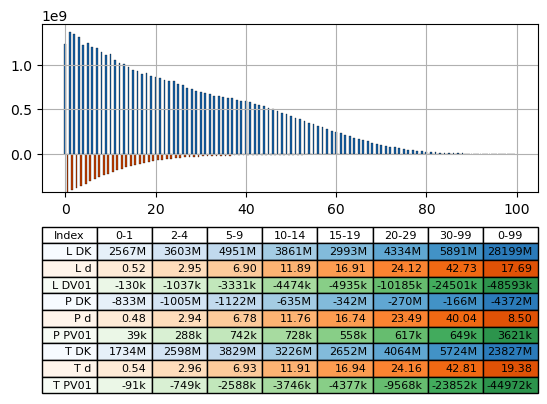

In [123]:
def main_t():
    a = TarEng()
    a.ParseTask("G;iTech;g=0;x=20;s=110;fB=0;fM=1000000")
    a.vPlot()

    strTask = "A;iTech;g=0;x=55;b=60;s=90;fR=12000;fDeltaR=0.05"
    a.ParseTask(strTask)
    a.vPlot()

    strTask = "A2;iTech;g=0;g2=1;deltaxy=3;x=20;s=120;fR2=12000"
    a.ParseTask(strTask)
    a.vPlot()

import time
import sys
import matplotlib
import matplotlib.pyplot as plt



def GetTable(ppCF,iT=0.025, InpBuckets = [2,5,10,15,20,30,100]):
    cmap = matplotlib.colormaps['Blues']
    cmap2 = matplotlib.colormaps['Oranges']
    cmap3 = matplotlib.colormaps['Greens']
    dCF = np.zeros([100,3])
    for i in range(100):
        dCF[i,0]=np.sum(ppCF[i,ppCF[i,:]>=0])
        dCF[i,1]=np.sum(ppCF[i,ppCF[i,:]<0])
        dCF[i,2]=np.sum(ppCF[i,:])
    Label = ["Index"]
    buckets =[]
    iPrior = 0
    for i in InpBuckets:
        buckets.append(range(iPrior,i))
        Label.append("%d-%d"%(iPrior,i-1))
        iPrior=i
    buckets.append(range(0,100))
    iNrColbuckets = 1 + len(buckets)
    Label.append("%d-%d"%(0,99))
    #print(Label)
    #print(buckets)
    Data = []
    CellColor = []
    
    strName0 = ["L DK","P DK", "T DK"]
    strName1 = ["L d","P d", "T d"]
    strName2 = ["L DV01","P PV01", "T PV01"]
    
    CF = [dCF[:,0],dCF[:,1],dCF[:,2]]
    for l in range(3):
        lCF=np.reshape(CF[l],100)
        print(lCF.shape)
        #print(repr(lCF))
        LData0 = []
        LData1 = []
        LData2 = []
        LCol0 = []
        LCol1 = []
        LCol2 = []
        for i in range(1+len(buckets)):
            alpha = 1.*i/iNrColbuckets*0.8
            LCol0.append(cmap(alpha))
            LCol1.append(cmap2(alpha))
            LCol2.append(cmap3(alpha))
        LData0.append(strName0[l])
        LData1.append(strName1[l])
        LData2.append(strName2[l])
        for i in buckets:
            PVA=0
            PVB=0
            PVAD = 0
            for k in i:    
                PVA += lCF[k]*(1+iT)**(-k)
                PVAD += k * lCF[k]*(1+iT)**(-k)
                PVB += lCF[k]*(1+iT+1.e-4)**(-k)
            LData0.append("%.0fM"%((PVA)*1.e-6))
            if PVA != 0:
                LData1.append("%.2f"%(PVAD/PVA))
            else:
                LData1.append("n/m")
                              
            LData2.append("%.0fk"%((PVB-PVA)*1.e-3))
        Data.append(LData0)
        Data.append(LData1)
        Data.append(LData2)
        CellColor.append(LCol0)
        CellColor.append(LCol1)
        CellColor.append(LCol2)
    #print(repr(Data))
    return(Label,Data,CellColor)
 

def main():
    cmap = matplotlib.colormaps['Blues']
    cmap2 = matplotlib.colormaps['Oranges']
    cmap3 = matplotlib.colormaps['Greens']
    bFirst = True
    bArgs = False
    psymF = open("tarif.txt","w")
    bContinue = True
    psymParm = dict()
    psymParm["input"] = None
    psymParm["outdk"] = "dk.csv"
    psymParm["outcf"] = "cf.csv"
    psymParm["pic"] = "cf.pdf"
    bBatch = False
    if bArgs:
        print(sys.argv)
        if len(sys.argv) >=2:
            psymParm["input"] = sys.argv[1]
            bBatch = True
        if len(sys.argv) >=3:
            psymParm["outdk"] = sys.argv[2]
        if len(sys.argv) >=4:
            psymParm["outcf"] = sys.argv[3]
    while bContinue:
        if bBatch:
            strInput = "batch"
        else:
            strInput = input() 
        if "clear" in strInput:
            a.vClearInput()
            continue
        if "stop" in strInput:
            bContinue = False
            continue
        if "batch" in strInput:
            a = TarEng(bLevel=True,bTrace=False,bBatch=True)
            if psymParm["input"] == None:
                strInput = input("Batch File?")
                psymParm["input"] = strInput
            t0 = time.time()
            psymF2 = open(psymParm["input"],"r")
            all= psymF2.read()
            psymF2.close()
            lines = all.split("\n")
            iNrLines = len(lines)
            if iNrLines >10:
                bBig = True
                res = np.zeros([a.pGPar.nCF,2])
                dk = np.zeros([100,2])
            else:
                bBig = False
                res = np.zeros([a.pGPar.nCF,iNrLines])
                dk = np.zeros([100,iNrLines])
            iC = 0
            iLC = 0
            dDKTot = 0
            for i in lines:
                if iLC <10 or iLC % 1000 == 0:
                    print(iLC,":>",i,"<")
                iLC +=1
                a.ParseTask(i)
                strOut = a.strPrint()
                psymF.write(strOut)
                dDK = a.pOut.dDKPer[0]
                dDKTot += dDK
                if bBig:
                    if dDK >= 0: iIndex = 1
                    else: iIndex = 0
                    res[0:100,iIndex] += a.pOut.dCF[0:a.pGPar.nCF].transpose()
                    dk[0:100,iIndex] += a.pOut.dDKPer[0:100].transpose()   
                else:
                    res[0:100,iC] = a.pOut.dCF[0:a.pGPar.nCF].transpose()
                    dk[0:100,iC] = a.pOut.dDKPer[0:100].transpose() 
                    iC+=1
            np.savetxt(psymParm["outcf"], res, delimiter=";")
            np.savetxt(psymParm["outdk"], dk, delimiter=";")
            bContinue = False

            if bBig: iNrLines = 2

            xx=[]
            y=[]
            c=[]
            b=[]
            w=[]
            for i in range(0,a.pGPar.nCF):
                bH=0
                bL=0
                for j in range(0,iNrLines):
                    fCF = res[i,j]
                    if fCF>=0:
                        xOffset = 0
                        if bBig:
                            c.append(cmap(0.8))
                        else:
                            c.append(cmap(j*1./iNrLines))
                        fDeltaPlus = fCF
                        fDeltaMinus = 0
                        bPlus = True
                    else:
                        xOffset = 0.5
                        if bBig:
                            c.append(cmap2(0.8))
                        else:
                            c.append(cmap2(j*1./iNrLines))
                        fDeltaPlus = 0
                        fDeltaMinus = fCF
                        bPlus = False
            
                    xx.append(i+xOffset)
                    w.append(0.4)
                    if bPlus:
                       y.append(fCF)
                       b.append(bH)
                    else: 
                       y.append(-fCF)
                       b.append(bL+fCF)
                    bH+=fDeltaPlus
                    bL+=fDeltaMinus
            fig= plt.figure(1)
            fig.set_size_inches(11.7,8.3)
            f,ax=plt.subplots(2,1)
            plt.subplot(2,1,1)
            plt.bar(xx,y,bottom=b,color=c,width=w,edgecolor="k",linewidth=0.2)
            plt.grid(True)
            ax=plt.subplot(2,1,2)
            MyLables =["x","y","z"]
            Data = [["A",10,20],
                    ["B",30,50]]
            MyLables,Data,CellColors =GetTable(res)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            ax.set_frame_on(False)
            table=ax.table(cellText=Data, colLabels =MyLables,loc="center",cellColours=CellColors)
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            #plt.subplots_adjust(left=0.1,top=0.4)
                               
            plt.savefig(psymParm["pic"],dpi=1200)

            if dDKTot >1e9:
                print("DK Total %.3f bn"%(1.e-9*dDKTot))
            else:
                print("DK Total %.0f"%(dDKTot))
            print("Batch done --> exit (time elapsed %6.2f s)"%(time.time()-t0))
                
        else:
            if bFirst:
                a = TarEng()
                bFirst = False
            a.ParseTask(strInput)
            strOut = a.strPrint()
            psymF.write(strOut)
        #a.vPlot()
    psymF.close()

if __name__ == "__main__":
    main()
